CNN 스팸 메일 분류

데이터 로드 및 전처리
  - https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

In [1]:
# Data load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# 데이터 읽기
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename='spam.csv')
data = pd.read_csv('spam.csv', encoding='latin-1')
print(len(data))


5572


In [3]:
data[:10]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [4]:
# 필요없는 컬럼 삭제
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

# 일반 메일과 스팸을 0과 1로 변형
data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])
data[:10]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [5]:
# 중복된 데이터 제거
data.drop_duplicates(subset=['v2'], inplace=True)
len(data)

5169

<AxesSubplot:>

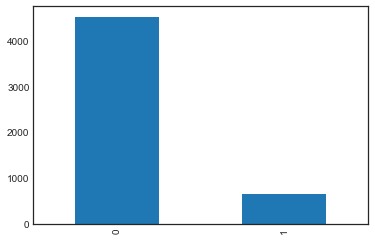

In [6]:
# 스팸과 일반 메일 개수 시각화하기
data['v1'].value_counts().plot(kind='bar')

In [7]:
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


In [8]:
x_data = data['v2']
y_data = data['v1']

In [9]:
vocab_size = 1000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(x_data)
sequences = tokenizer.texts_to_sequences(x_data)

sequences[:2]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6]]

In [14]:
# 메일 길이 확인
x_data = sequences

print('메일 최대 길이 : {}'.format(max(len(l) for l in x_data)))
print("메일 평균 길이 : {}".format((sum(map(len, x_data))/len(x_data))))

메일 최대 길이 : 172
메일 평균 길이 : 12.566840781582512


Text(0, 0.5, 'Number of Samples')

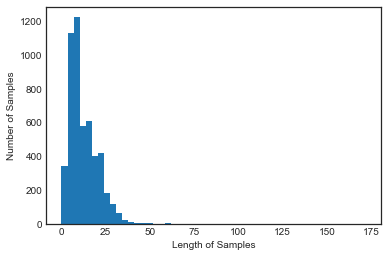

In [15]:
# 각 데이터의 메일 길이와 개수 시각화

plt.hist([len(s) for s in x_data], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')

In [16]:
# 메일 길이가 60 이상 되는 것은 개수가 거의 없기 때문에 메일 길이 최대치를 60까지 한정시킨다

max_len = 60
data = pad_sequences(x_data, maxlen=max_len)
print(data.shape)

(5169, 60)


In [19]:
# train과 test 분리

n_train = int(len(sequences) * 0.8)
n_test = int(len(sequences) - n_train)

x_train = data[:n_train]
y_train = np.array(y_data[:n_train])
x_test = data[n_train:]
y_test = np.array(y_data[n_train:])

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4135, 60) (4135,) (1034, 60) (1034,)


모델 구성

In [20]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPool1D, Embedding, Dropout, MaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [22]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Dropout(0.2))
model.add(Conv1D(32, 5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          32000     
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          5152      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

모델 학습

In [24]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.5090 - acc: 0.8452
Epoch 00001: val_acc improved from -inf to 0.87304, saving model to best_model.h5
52/52 [==============================] - 10s 12ms/step - loss: 0.5090 - acc: 0.8452 - val_loss: 0.3819 - val_acc: 0.8730
Epoch 2/10
51/52 [============================>.] - ETA: 0s - loss: 0.3760 - acc: 0.8704
Epoch 00002: val_acc did not improve from 0.87304
52/52 [==============================] - 0s 8ms/step - loss: 0.3768 - acc: 0.8697 - val_loss: 0.3289 - val_acc: 0.8730
Epoch 3/10
51/52 [============================>.] - ETA: 0s - loss: 0.2075 - acc: 0.9170
Epoch 00003: val_acc improved from 0.87304 to 0.98065, saving model to best_model.h5
52/52 [==============================] - 0s 9ms/step - loss: 0.2069 - acc: 0.9172 - val_loss: 0.0791 - val_acc: 0.9807
Epoch 4/10
49/52 [===========================>..] - ETA: 0s - loss: 0.0564 - acc: 0.9869
Epoch 00004: val_acc improved from 0.98065 to 0.98428, saving model 

시각화

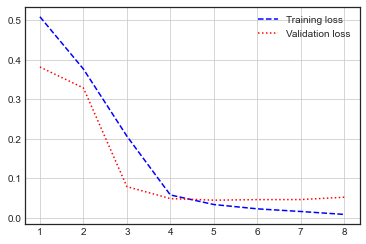

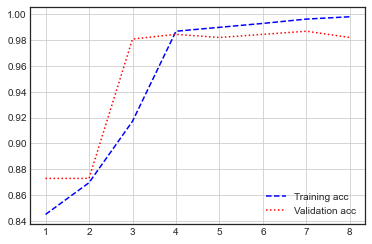

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) +1)

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'r:', label='Validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'r:', label='Validation acc')
plt.grid()
plt.legend()

평가

In [27]:
model.evaluate(x_test, y_test)

33/33 [==============================] - 0s 4ms/step - loss: 0.0653 - acc: 0.9826


[0.06526460498571396, 0.9825918674468994]